In [1]:
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('scripts/')
import lcwgSus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

/gpfs3/well/band/users/rbx225/GAMCC


SNPs can be dropped by `bcftools` using this command:
`bcftools view -T ^drop.tsv input.vcf > output.vf`
where `drop.tsv`has two columns: chr and pos.

In [31]:
db = sqlite3.connect( "results/chip/qc/chip.qc.sqlite" )
snp = pd.read_sql_query( "SELECT * FROM autosomesView", db )
sample = pd.read_sql_query( "SELECT * FROM sample_statsView", db )
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample_id'})
PC = pd.read_sql_query( "SELECT * FROM PCsView", db )
PC = PC[PC['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC = PC.merge(ethnic, on = 'sample_id', how = 'left')

(array([1.3818e+04, 2.8940e+03, 1.0100e+02, 1.9000e+01, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.0237852 , -0.00173558,  0.02031404,  0.04236366,  0.06441328,
         0.0864629 ,  0.10851252,  0.13056214,  0.15261176,  0.17466138,
         0.196711  ]),
 <BarContainer object of 10 artists>)

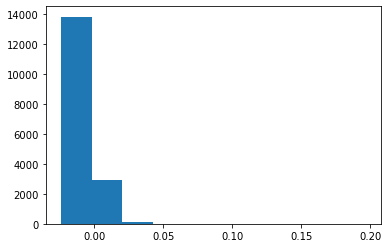

In [37]:
kinship = pd.read_csv( "results/chip/qc/PCs/S1025_2023_01-02_kinship_thin_1bp.exclude-duplicates.tsv.gz", comment = '#', sep = '\t')
plt.hist(kinship[kinship['sample_1'] != kinship['sample_2']]['value'])

In [3]:
snp = snp[snp['missing_proportion'] < 0.2]
snp = snp[snp['HW_exact_p_value'] < 1e-6]

sample = sample[sample['missing_proportion']<0.2]
std = sample['heterozygous_proportion'].std()
mean = sample['heterozygous_proportion'].mean()
sample = sample[(sample['heterozygous_proportion'] > mean - 3*std) & (sample['heterozygous_proportion'] < mean + 3*std)]

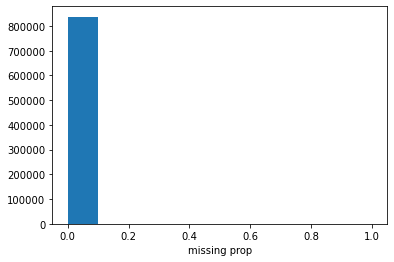

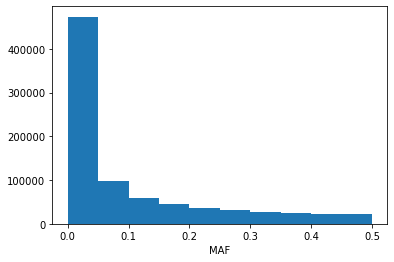

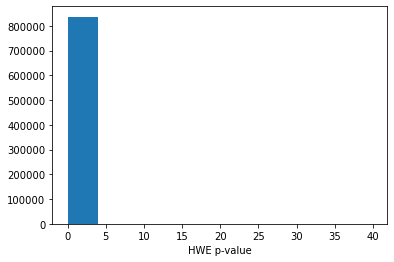

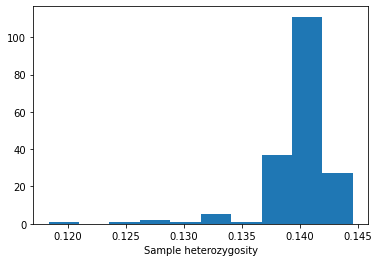

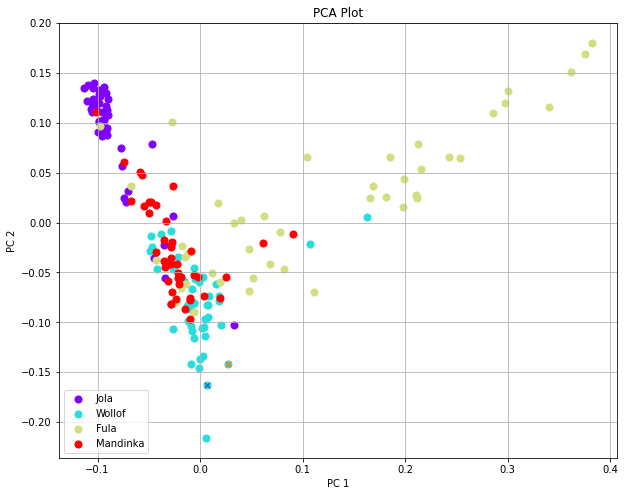

In [42]:
plt.hist(snp['missing_proportion'])
plt.xlabel('missing prop')
plt.show()

plt.hist(snp['minor_allele_frequency'])
plt.xlabel('MAF')
plt.show()

plt.hist(-np.log10(snp['HW_exact_p_value']))
plt.xlabel('HWE p-value')
plt.show()

plt.hist(sample['heterozygous_proportion'])
plt.xlabel('Sample heterozygosity')
plt.show()

plt.figure(figsize=(10, 8))

labels = PC['ethnic']
targets = labels.unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(targets)))
for target, color in zip(targets, colors):
    indices_to_keep = labels == target
    plt.scatter(
        PC.loc[indices_to_keep, 'PC_1'],
        PC.loc[indices_to_keep, 'PC_2'],
        color=color,
        label=target,
        s=50,
    )

plt.scatter(PC[PC['sample_id'] == 'GAM654203']['PC_1'], PC[PC['sample_id'] == 'GAM654203']['PC_2'], marker = 'x', s = 30)
plt.scatter(PC[PC['sample_id'] == 'GAM847516']['PC_1'], PC[PC['sample_id'] == 'GAM847516']['PC_2'], marker = 'x', s = 30)

plt.legend()
plt.title('PCA Plot')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

In [45]:
kinship[(kinship['sample_2'] == 'GAM654203') & (kinship['sample_1'] == 'GAM847516')]

,sample_1,sample_2,pairwise.complete.obs,value
13982,GAM847516,GAM654203,513146,0.196711


In [47]:
kinship[kinship['value'] < 0.8].sort_values(by = 'value')

,sample_1,sample_2,pairwise.complete.obs,value
3445,GAM436921,GAM194528,513992,-0.023785
2860,GAM396452,GAM047269,511845,-0.023534
8656,GAM694875,GAM047269,514707,-0.023230
3733,GAM456970,GAM413570,514796,-0.022899
3034,GAM412603,GAM156837,514619,-0.022841
...,...,...,...,...
934,GAM194528,GAM156837,513974,0.064187
5226,GAM568072,GAM396452,512024,0.066537
3493,GAM438965,GAM042576,515054,0.068545
3775,GAM469107,GAM164079,514825,0.111015
